In [100]:
import os

os.chdir("/home/weedsci/matt/SemiF-AnnotationPipeline")
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
from semif_utils.utils import make_exg, make_kmeans, otsu_thresh, reduce_holes, make_exg_minus_exr, apply_mask, crop_cutouts, get_image_meta, thresh_vi, contour_mask
from semif_utils.segment_utils import  prep_bbox
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)
import cv2
from scipy import ndimage as ndi
from segment_species import Segment
from image_source_canny import canny


In [121]:
metadir = Path("data/semifield-developed-images/NC_2022-07-14/metadata/")
# random.seed(42)

labels = [str(x) for x in (metadir).glob("*.json")]
print(len(labels))
def is_green(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower = np.array([40, 70, 120])
    upper = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    print(np.sum(mask))
    return True if np.sum(mask)> 20000 else False 



722


In [122]:
rdn = random.randint(0,15)
sample = random.sample(labels, rdn)
for label in sample:
    imgdata = get_image_meta(label)
    # Call image array
    rgb_array = imgdata.array
    # Get bboxes
    bboxes = imgdata.bboxes
    ## Process on images by individual bbox detection
    cutout_num = 0
    cutout_ids = []
    # for box in bboxes:
    num = 0
    for box in bboxes:
        scale = [imgdata.fullres_width, imgdata.fullres_height]
        _, x1, y1, x2, y2 = prep_bbox(box, scale)
        # Crop image to bbox
        rgb_crop = rgb_array[y1:y2, x1:x2]
        if rgb_crop.shape[0] < 1000:
            continue
        if rgb_crop.max()== 0:
            continue
        # otsu = Segment(rgb_crop).general_seg(mode="threshold")
        # kmeans = Segment(rgb_crop).general_seg(mode="cluster")
        # water = Segment(rgb_crop).watershed(img_type="vi", kernel=(5,5))
        # multi = Segment(rgb_crop).multi_otsu()
        # lamb = Segment(rgb_crop).lambsquarters(cotlydon=False)
        # lamb_coty = Segment(rgb_crop).lambsquarters(cotlydon=True)
        mask = Segment(rgb_crop).general_seg(mode="cluster")
        cutout_2 = apply_mask(rgb_crop, mask, "black")
        
        print(is_green(cutout_2))
        # f, ax = plt.subplots(1,5, figsize=(12,8))
        # ax[0,0].imshow(otsu)
        # ax[0,0].set_axis_off()
        plt.imshow(cutout_2)
        plt.show()
        # ax[0].imshow(rgb_crop)
        # ax[0].set_axis_off()

        # ax[1].imshow(thresh_vi(make_exg(rgb_crop)))
        # ax[1].set_axis_off()

        # ax[2].imshow(multi)
        # ax[2].set_axis_off()

        # # ax[1,0].imshow(lamb)
        # # ax[1,0].set_axis_off()

        # ax[3].imshow(lamb_coty)
        # ax[3].set_axis_off()
        # kernel = np.ones((3,3),np.uint8)
        # closing = cv2.morphologyEx(lamb_coty.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
        # mask = cv2.cvtColor(closing*255, cv2.COLOR_GRAY2RGB)
        
        # cutout = cv2.bitwise_and(rgb_crop, mask)
        # ax[4].imshow(cutout)
        # ax[4].set_axis_off()

        # f.tight_layout()
        # f.savefig(f"Assets/lambsquarters_tests_{num}.png", dpi=600, transparent=True)
        num += 1


## Analyze components

In [17]:
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
import seaborn as sns
import cv2
label_img = label(multi>0, connectivity=2)

# props = [x.area for x in measure.regionprops(label_img, rgb_crop)]
props = regionprops_table(label_img,thresh_vi(make_exg(rgb_crop)), properties=('area',
                                                 'eccentricity',
                                                 'label',
                                                 'solidity',
                                                 'perimeter',
                                                 'image_intensity',
                                                 'intensity_mean',
                                                 'moments',
                                                 'inertia_tensor_eigvals',
                                                 'orientation',
                                                 'axis_major_length',
                                                 'axis_minor_length'))
df = pd.DataFrame(props)
# df["intensity_mean"] = (df["intensity_mean-0"] + df["intensity_mean-1"] + df["intensity_mean-2"])/ 3
df.head()

,area,eccentricity,label,solidity,perimeter,image_intensity,intensity_mean,moments-0-0,moments-0-1,moments-0-2,...,moments-2-3,moments-3-0,moments-3-1,moments-3-2,moments-3-3,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1,orientation,axis_major_length,axis_minor_length
0,1,0.000000,1,1.000,0.00000,[[50]],50.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.785398,0.000000,0.000000
1,1,0.000000,2,1.000,0.00000,[[46]],46.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.785398,0.000000,0.000000
2,7,0.643079,3,0.875,6.62132,"[[64, 0, 0], [58, 56, 0], [54, 70, 70], [46, 0...",59.714286,7.0,4.0,6.0,...,37.0,53.0,25.0,41.0,73.0,0.849027,0.497912,0.310125,3.685707,2.822514
3,1,0.000000,4,1.000,0.00000,[[54]],54.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.785398,0.000000,0.000000
4,1,0.000000,5,1.000,0.00000,[[48]],48.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.785398,0.000000,0.000000


<AxesSubplot:xlabel='area', ylabel='intensity_mean'>

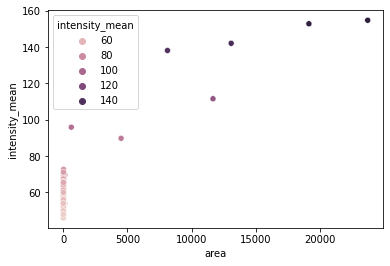

In [18]:
sns.scatterplot(x='area', y='intensity_mean', data=df, hue='intensity_mean')

Text(0.5, 1.0, 'Solidity')

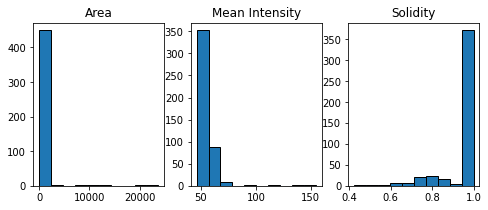

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].hist(df['area'], edgecolor="k")
ax[1].hist(df['intensity_mean'], edgecolor="k")
ax[2].hist(df['solidity'], edgecolor="k")
ax[0].set_title("Area")
ax[1].set_title("Mean Intensity")
ax[2].set_title("Solidity")
